# Skincare products 

## Sales prediction

In the following study data on sales for 10 skincare products distributed via 6 channels over 4 years was analysed. Information on the advertisements campaigns was used to estimate the effects on promotions on the sales. Using the advertisement info 3 unique product lines were highlighted. The inter-correlations as well as variances of the features were studied. 
For modelling the data were subdivided into yearly subsets. Nested cross-validation was used to estimate the consistancy of the data on yearly basis. For modelling and predictive analysis linear regression was used.

## Outlook

The data was successfully modeled and the forecast was built. Linear regression has shown reasonable results in the forecasting. Possibly the quality may be further improved via introduction of more advanced Machine Learning modelling techniques, e. g. ensambles or boosted algorithms.

In [1]:
import math
import pandas as pd 
import numpy as np
from statistics import mean 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import warnings                   
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

Define functions for future

In [2]:
def rescale(df, colname):
    df[colname] = (df[colname] - min(df[colname])) / (max(df[colname]) - min(df[colname]))
    
def compute_R2(y_true, y_pred):
    y_true_list = y_true.values.tolist()
    y_pred_list = y_pred.values.tolist()
    
    y_true_mean = mean(y_true_list)
    
    u = 0
    v = 0
    for i in range(len(y_true_list)):
        u += ((y_true_list[i] - y_pred_list[i]) ** 2)
        v += ((y_true_list[i] - y_true_mean) ** 2)
    R2 = 1 - u / v
    return R2

def split_df_year_cols(df, year, cols, test = True, single_year = True):
    if test:
        temp = df[(df.year > year) & (df.year <= (year + 1))] #take only the next year after the trainset for tests
    else:
        if single_year:
            temp = df[(df.year <= year) & (df.year > (year - 1))] #take only one year
        else:
            temp = df[df.year <= year]
        
    fragment = temp[cols]
    
    return fragment

Load data

In [3]:
df_A = pd.read_csv("PartA.csv")
df_B = pd.read_csv("PartB.csv")

Check for duplicates

In [4]:
df_A.loc[df_A.duplicated()].head()

,Product,Channel,WeekStart,QuantitySold,Price,isPromoPeriod
425,TXX06,C,2015-04-27,13928,4.524835,True
542,TXZ06,B,2015-03-16,130,3.287736,False
590,TXX00,E,2015-03-02,134,3.427500,True
638,TXX5Q,B,2015-02-23,88,5.890278,False
708,TXX06,C,2015-04-20,13648,4.522718,True


In [5]:
df_B.loc[df_B.duplicated()]

,Product,Channel,WeekStart,TV,Online,StoresAvailability


Drop duplicates in the first Data Frame

In [6]:
df_A = df_A.drop_duplicates()

Join Data Frames into one dataset

In [7]:
left = df_A.set_index(['WeekStart', 'Channel', 'Product'])
right = df_B.set_index(['WeekStart', 'Channel', 'Product'])

df_all = left.join(right)
df_all.head(10)

,,,QuantitySold,Price,isPromoPeriod,TV,Online,StoresAvailability
WeekStart,Channel,Product,,,,,,
2017-01-23,E,TXX5Q,75,3.537000,True,0.00,0.000,47
2016-10-03,E,TXQT7,191,8.914645,True,170590.61,9574.474,48
2015-10-05,E,TXX5Q,111,3.483462,True,0.00,0.000,53
2016-08-08,C,TXQ0T,15312,4.784056,True,0.00,0.000,90
2017-11-13,C,TXQQX,12756,1.334446,True,208647.18,42411.096,37
2015-06-29,B,TXX00,75,5.514754,False,0.00,0.000,34
2017-05-29,C,TXQT7,11871,10.552014,True,0.00,0.000,85
2017-03-20,E,TXZ06,413,2.030239,True,0.00,0.000,71
2015-11-09,B,TXX5Q,38,6.490323,False,0.00,0.000,15


In [8]:
df_all.isnull().values.any()

False

Check column types

In [9]:
df_all.sort_values(by = 'WeekStart', inplace = True)

In [10]:
df_all.reset_index(inplace = True)

In [11]:
df_all.dtypes

WeekStart              object
Channel                object
Product                object
QuantitySold            int64
Price                 float64
isPromoPeriod            bool
TV                    float64
Online                float64
StoresAvailability      int64
dtype: object

WeekStart column should be transformed to datetime type.
isPromoPeriod column should be transformed to int type.

In [12]:
df_all['WeekStart']= pd.to_datetime(df_all['WeekStart'])

In [13]:
df_all.isPromoPeriod = df_all.isPromoPeriod.astype(int)

Add categorical values for all products and Channels (one hot encoding).

In [14]:
list_of_prods = sorted(df_all.Product.unique())
list_of_channels = sorted(df_all.Channel.unique())

In [15]:
for prod in list_of_prods:
    df_all[prod] = [int(value == prod) for value in df_all.Product]

for ch in list_of_channels:
    df_all[ch] = [int(value == ch) for value in df_all.Channel]

The costs on the adds have to be distributed among products of the same product line within one campaign. 
Find these product lines for the TV and Online ads.

In [16]:
non_zero_ads_tv = df_all[df_all.TV != 0].sort_values(by = 'TV')
tv_ad_groups = non_zero_ads_tv.groupby(non_zero_ads_tv.TV).Product.unique()

for i in tv_ad_groups.index:
    tv_ad_groups[i] = sorted(tv_ad_groups[i])

tv_ads_prod_list = list(set(tuple(i) for i in tv_ad_groups.tolist()))
tv_ads_prod_list

[('TXX00', 'TXX06', 'TXXX0', 'TXZ06'),
 ('TXX00', 'TXX06', 'TXXX0', 'TXZ06', 'TZQAQ'),
 ('TXQQX', 'TXQT7', 'TXQTZ'),
 ('TXQT7', 'TXQTZ')]

In [17]:
non_zero_ads_online = df_all[df_all.Online != 0].sort_values(by = 'Online')
online_ad_groups = non_zero_ads_online.groupby(non_zero_ads_online.Online).Product.unique()

for i in online_ad_groups.index:
    online_ad_groups[i] = sorted(online_ad_groups[i])

web_ads_prod_list = list(set(tuple(i) for i in online_ad_groups.tolist()))
web_ads_prod_list

[('TXX00', 'TXX06', 'TXXX0', 'TXZ06'),
 ('TXX00', 'TXX06', 'TXXX0', 'TXZ06', 'TZQAQ'),
 ('TXQQX', 'TXQT7', 'TXQTZ'),
 ('TXQ0T', 'TXX5Q')]

Check if any product does not appear in any of the product lines.

In [18]:
products_out_of_lines = 0

for prod in list_of_prods:
    not_in_line = 0
    for prod_line_set in (web_ads_prod_list, tv_ads_prod_list):
        for line in prod_line_set:
            if prod not in line:
                not_in_line += 1
    if not_in_line == (len(web_ads_prod_list) + len(tv_ads_prod_list)):
        print('Product ' + prod + 'appear in neither of product lines')
        products_out_of_lines += 1
        
if products_out_of_lines == 0:
    print('All of the products appear at least in one of the product lines.')

All of the products appear at least in one of the product lines.


Create a list of major product lines (should include all 10 products)

In [19]:
list_of_prodlines = sorted(list(set(web_ads_prod_list + tv_ads_prod_list)))
list_of_prodlines.remove(list_of_prodlines[2])
list_of_prodlines.remove(list_of_prodlines[2])
list_of_prodlines = sorted(list_of_prodlines)
list_of_prodlines

[('TXQ0T', 'TXX5Q'),
 ('TXQQX', 'TXQT7', 'TXQTZ'),
 ('TXX00', 'TXX06', 'TXXX0', 'TXZ06', 'TZQAQ')]

Rescale the 'Price', 'StoresAvailability', 'TV', 'Online', columns to the range [0..1]

In [20]:
rescale_list = ['Price', 'StoresAvailability', 'TV', 'Online']
for colname in rescale_list:
   rescale(df_all, colname)

Add few additional time features for future use. 

In [21]:
df_all['year'] = [date.year for date in df_all['WeekStart']]
df_all['month'] = [date.month for date in df_all['WeekStart']]
df_all['day'] = [date.day for date in df_all['WeekStart']]

Check statistics of the data set between years

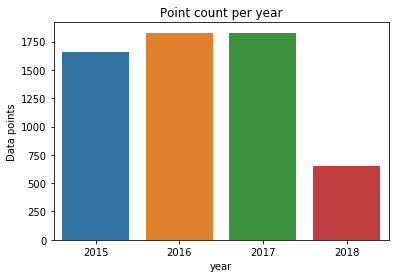

In [22]:
unique_years = df_all.groupby(by = 'year').WeekStart.count()
sns.barplot(unique_years.index, unique_years.values)
plt.ylabel('Data points')

plt.title('Point count per year')
plt.show()

Data is distributed quite uniformly among the first three years. The last year is preasent only in part.

Check statistics of the data set between years

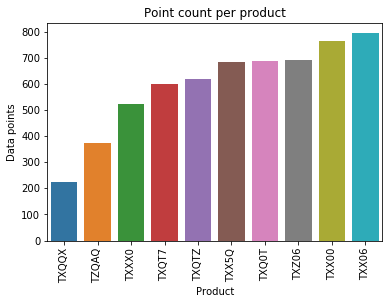

In [23]:
product_counts = df_all.groupby(by = 'Product').WeekStart.count().sort_values()

sns.barplot(product_counts.index, product_counts.values)
plt.ylabel('Data points')
plt.xticks(rotation=90)
plt.title('Point count per product')

plt.show()

The product 'TXX06' shows has the largest number of points.

Check points count per product per year

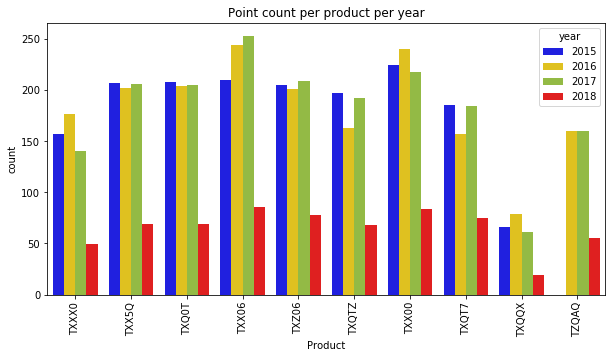

In [24]:
year_palette ={2015:"blue",
               2016:"gold",
               2017:"yellowgreen", 
               2018:"red"}

plt.figure(figsize = (10, 5))

sns.countplot(x = 'Product', hue = 'year', data = df_all, palette = year_palette)

plt.title('Point count per product per year')
plt.xticks(rotation=90)

plt.show()

The yearly proportion of the data for each of the products is relatively similsr.

Point count per product per Channel.

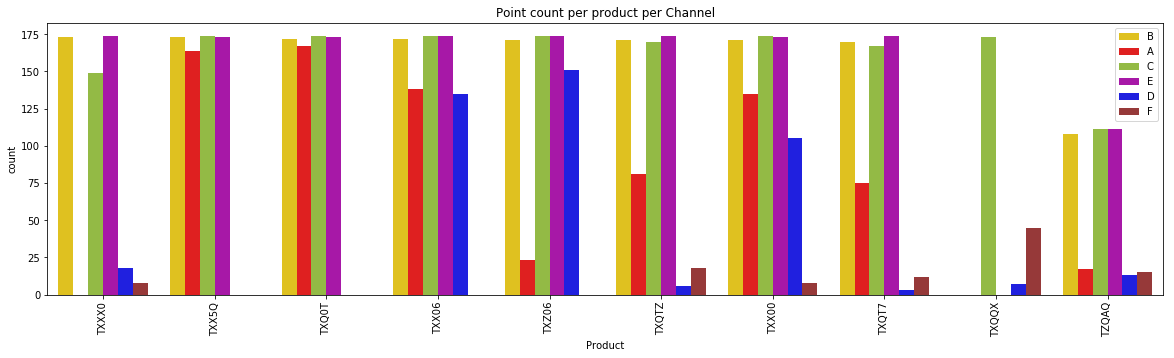

In [25]:
ch_palette ={"A":"red",
          "B":"gold",
          "C":"yellowgreen", 
          "D":"blue",
          "E":"m", 
          "F":"brown"}

plt.figure(figsize = (20, 5))
sns.countplot(x = 'Product', hue = 'Channel', data = df_all, palette=ch_palette)

plt.title('Point count per product per Channel')
plt.xticks(rotation=90)
plt.legend(loc = 'upper right')

plt.show()

In [26]:
mean_sales = pd.pivot_table(df_all, values = 'QuantitySold', 
                            index = 'Product', columns = 'Channel', 
                            aggfunc = np.mean, fill_value = 0)

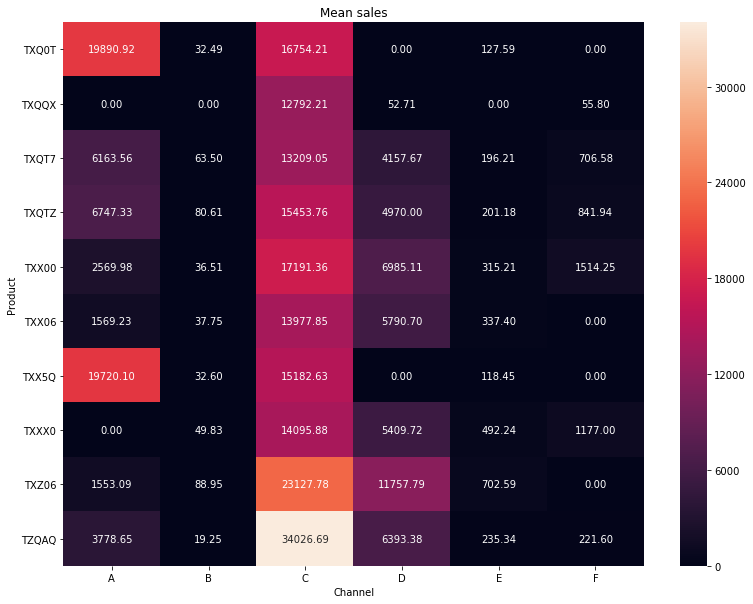

In [27]:
plt.figure(figsize = (13, 10))
sns.heatmap(mean_sales, annot=True, fmt=".2f")

plt.title('Mean sales')
plt.yticks(rotation=0) 
plt.show()

From the map of mean sales it is clear, some of the Products/Channels demonstrate sales below ~1000 and the others are above. The borderline is obviously arbitrary.

Check the correlations of sales with Prices and StoresAvailability. 

In [28]:
product_names = product_counts.index
product_df_list = []
for name in product_names:
    product_df_list.append(df_all[df_all['Product'] == name])
    
for i, df in enumerate(product_df_list):
    df.set_index('WeekStart', inplace = True)

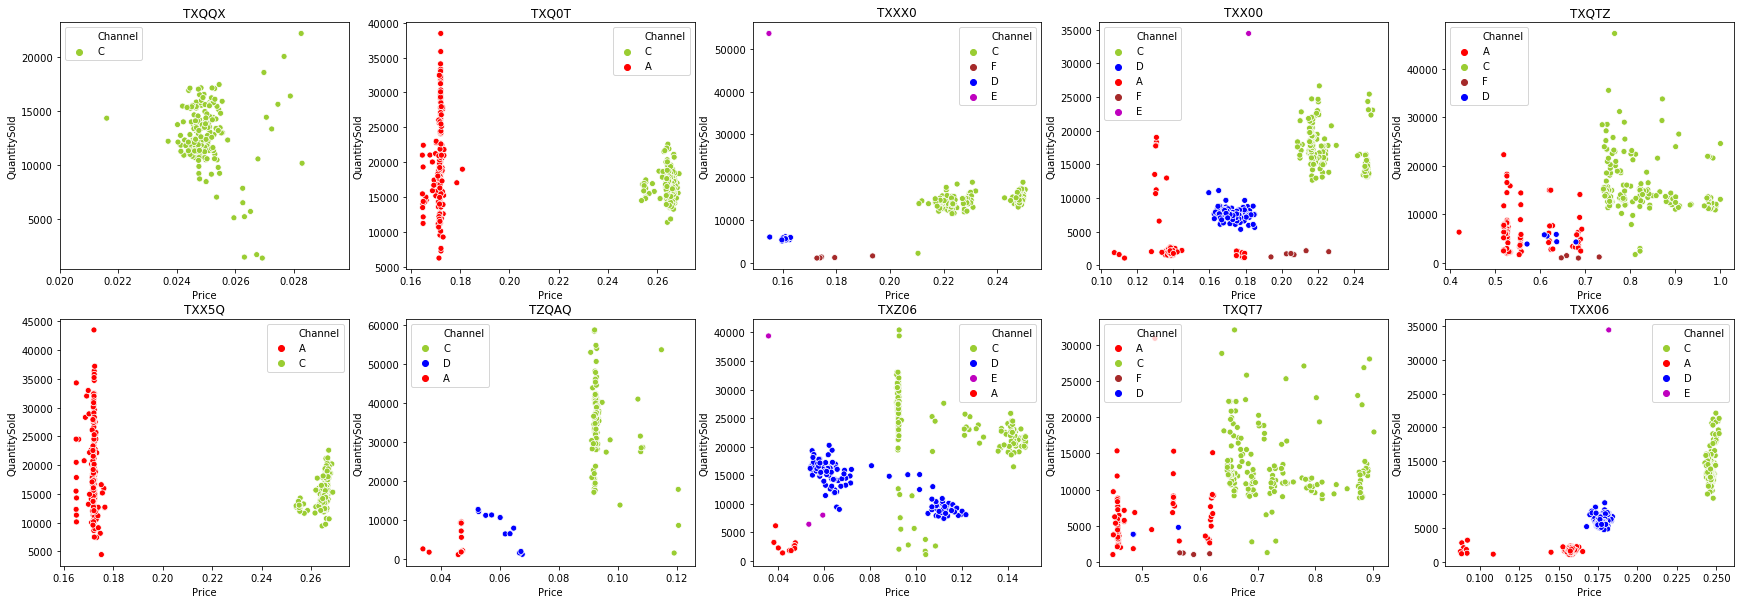

In [29]:
fig, axs = plt.subplots(figsize=(30, 10), ncols=5, nrows=2)

for i, df in enumerate(product_df_list):
    sns.scatterplot(data = product_df_list[i][product_df_list[i]['QuantitySold'] > 1000], 
                    x = 'Price', 
                    y = 'QuantitySold', 
                    hue = 'Channel',
                    palette=ch_palette,
                    ax = axs[i % 2][i % 5])
    axs[i % 2][i % 5].set_title(product_df_list[i]['Product'].iloc[0])
    
    #axs[i % 2][i % 5].set_ylim(1000)

plt.show()

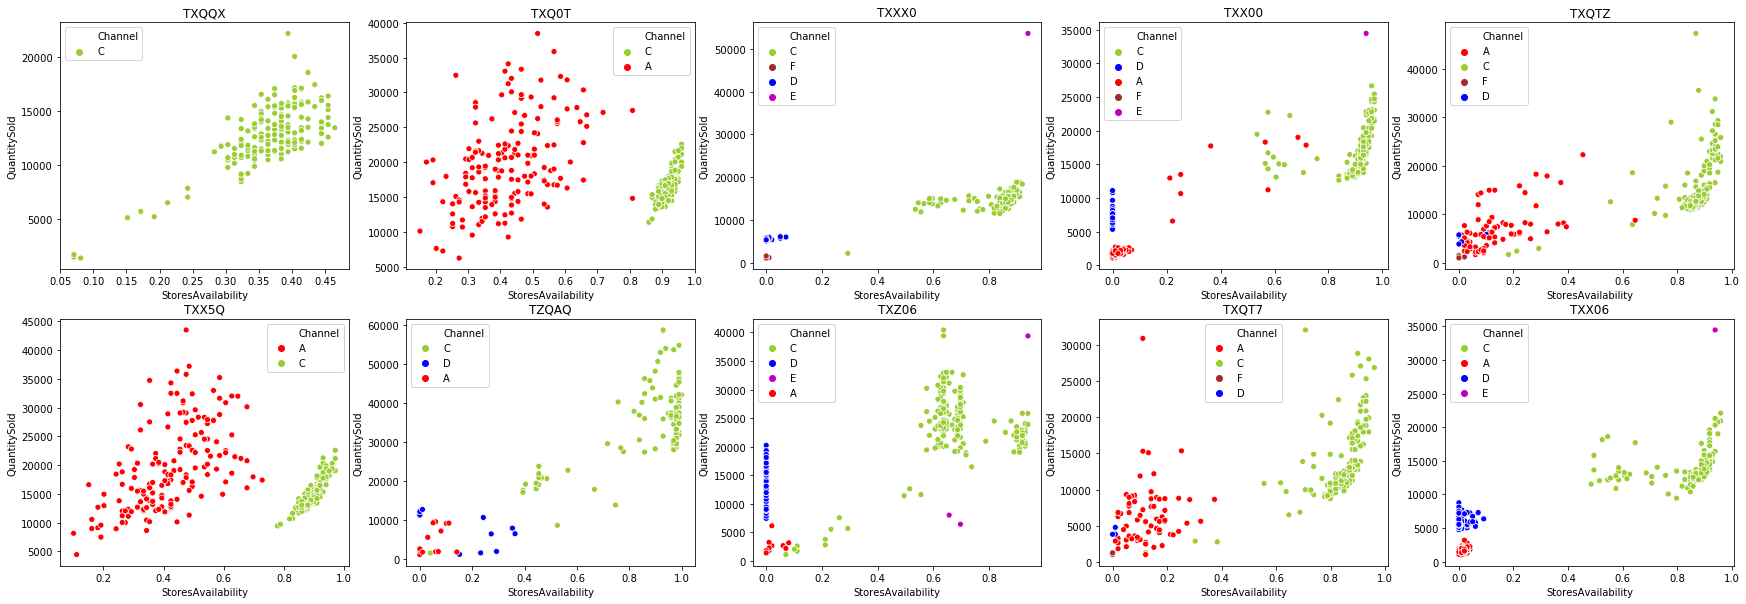

In [30]:
fig, axs = plt.subplots(figsize=(30, 10), ncols=5, nrows=2)

for i, df in enumerate(product_df_list):
    sns.scatterplot(data = product_df_list[i][product_df_list[i]['QuantitySold'] > 1000], 
                    x = 'StoresAvailability', 
                    y = 'QuantitySold', 
                    hue = 'Channel',
                    palette=ch_palette,
                    ax = axs[i % 2][i % 5])
    axs[i % 2][i % 5].set_title(product_df_list[i]['Product'].iloc[0])
    
    #axs[i % 2][i % 5].set_ylim(1000)

plt.show()

Various channels can be devided into groups of high and low sales. This may need to be taken care of in the further analysis.

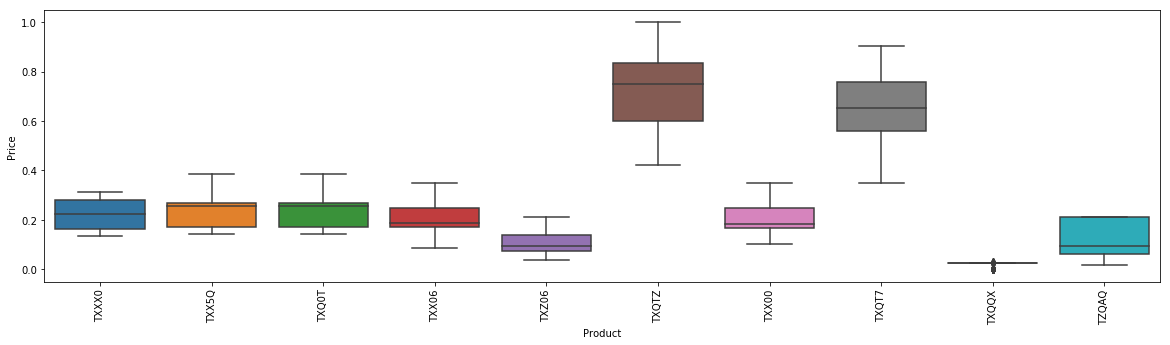

In [31]:
plt.figure(figsize = (20, 5))
sns.boxplot(data = df_all, x = 'Product', y = 'Price')

plt.xticks(rotation=90)
plt.show()

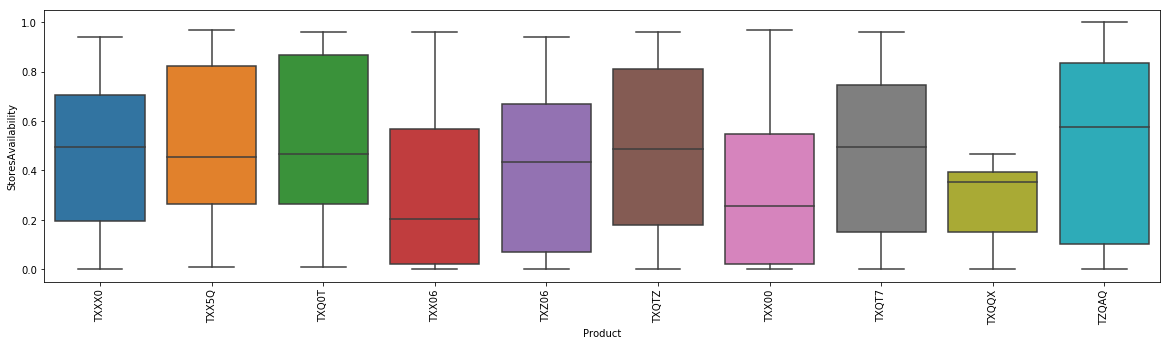

In [32]:
plt.figure(figsize = (20, 5))
sns.boxplot(data = df_all, x = 'Product', y = 'StoresAvailability')

plt.xticks(rotation=90)
plt.show()



There are sets of data for 4 years. 2015, 2016 and 2017 have similar statisics. 

2018 part is smaller - potentially a good set for future model validation.

Make time series plot, marking years and weeks, where the add campaigns were run.
Use only one product and one channel for clearance.

Use the product 'TXX06' and the channel 'C' (the larger statistics).

In [33]:
df_all.set_index('WeekStart', inplace = True)

In [34]:
single_prod_ch_df = df_all[(df_all.Product == 'TXX06') & 
                           (df_all.Channel == 'C')].reset_index().set_index('WeekStart')

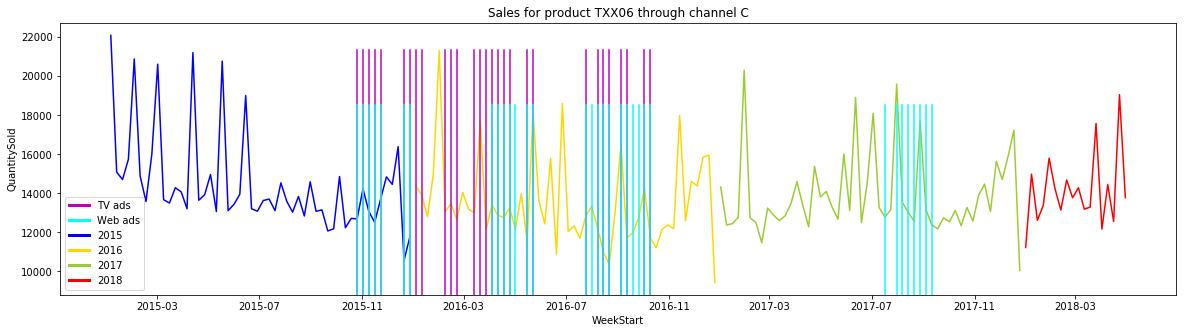

In [35]:
plt.figure(figsize=(20,5))

sns.lineplot(data = single_prod_ch_df,
             x = single_prod_ch_df.index,
             y = 'QuantitySold',
             hue = 'year',
             palette=year_palette,
             estimator=None,
             ci=None)
for index ,row in single_prod_ch_df.iterrows():
    if row['TV'] > 0:
        plt.axvline(index, 0,0.9, color = 'm')
for index ,row in single_prod_ch_df.iterrows():
    if row['Online'] > 0:
        plt.axvline(index, 0,0.7, color = 'cyan')
        
plt.title('Sales for product TXX06 through channel C')
colors = ['m', 'cyan', 'blue', 'gold', 'yellowgreen', 'red']
lines = [Line2D([0], [0], color = c, linewidth = 3, linestyle = '-') for c in colors]
labels = ['TV ads', 'Web ads', '2015', '2016', '2017', '2018']
plt.legend(lines, labels)
plt.show()

The data are in form of time series. This means, the usual approach to the cross-validation (e. g. k-fold) will be not ideal, since it is important to preserve the temporal dependencies and prevent possible data leackage. So an arbitrary choice of a test set would not work.

Try to use a Nested-cross-validation approach in splitting the dataset.

In [36]:
x_cols = list(filter(lambda x: not (x in ['Channel', 'Product', 'QuantitySold', 
                                          #'year', 
                                          'month', 'day', 
                                          'isPromoPeriod', 
                                          'TV', 'Online']), 
                     df_all.columns))
y_cols = 'QuantitySold'

In [37]:
year_list = unique_years.index.to_list()
year_list.remove(year_list[-1])
x_train = []
x_test = []
y_train = []
y_test = []

for i, year in enumerate(year_list):
    x_train.append(split_df_year_cols(df_all, year, x_cols, test = False, single_year = False))
    y_train.append(split_df_year_cols(df_all, year, y_cols, test = False, single_year = False))
    
    x_test.append(split_df_year_cols(df_all, year, x_cols, test = True))
    y_test.append(split_df_year_cols(df_all, year, y_cols, test = True))

Fit a multivariate linear regression to product lines.

In [38]:
list_of_channels = list(set(df_all['Channel']))

*********************************************************
Product line ('TXQ0T', 'TXX5Q')
*********************************************************
[ 1.36123043e+04  2.40287743e+04  2.22787548e+02  0.00000000e+00
  5.45696821e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.22787548e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.57435656e+04 -4.21608799e+03 -3.05185047e+03  0.00000000e+00
 -8.47562717e+03  0.00000000e+00]
The R-square_train is:  0.9071906293476361
The R-square_test is:  0.87553850795373


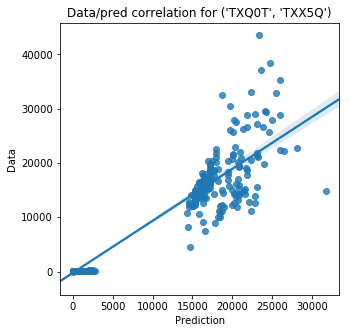

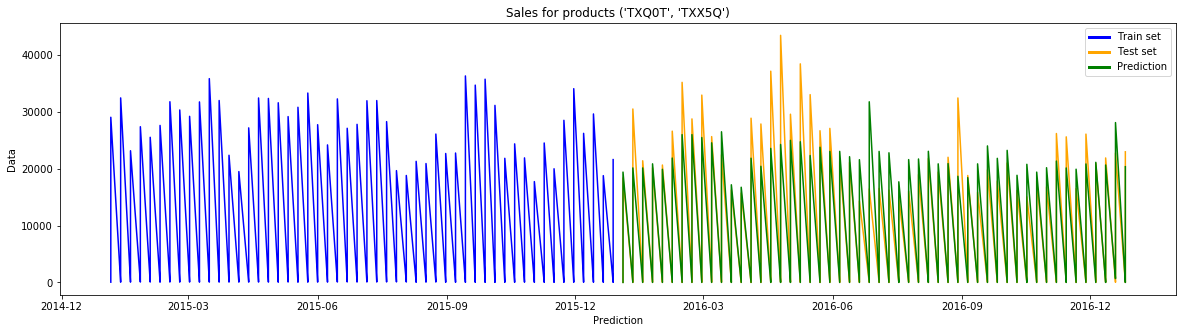

[ 2.23806653e+04  1.94091216e+04 -6.35351073e+17 -9.35499852e+14
 -3.38153426e+15 -2.90574015e+15 -1.28000000e+02  0.00000000e+00
 -6.35351073e+17  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.10131855e+16  1.10131855e+16  1.10131855e+16  0.00000000e+00
  1.10131855e+16  0.00000000e+00]
The R-square_train is:  0.8851177243725735
The R-square_test is:  0.8854804360021499


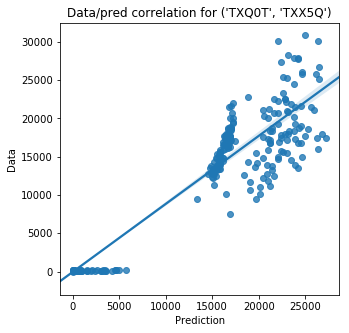

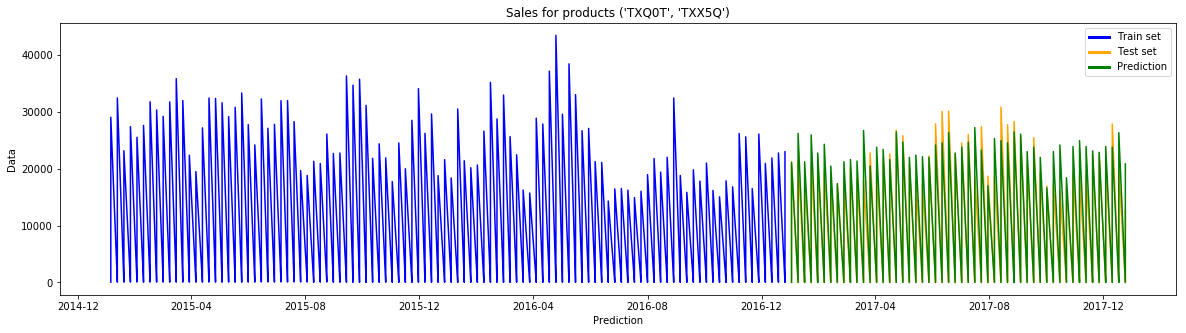

[ 1.32644672e+04  1.60194058e+04  5.70497293e+17  3.69178647e+16
 -2.79618681e+16 -6.31011117e+15  0.00000000e+00  6.40000000e+01
  5.70497293e+17  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -8.34512647e+16 -8.34512647e+16 -8.34512647e+16  0.00000000e+00
 -8.34512647e+16  0.00000000e+00]
The R-square_train is:  0.8862044583988135
The R-square_test is:  0.8239261413564893


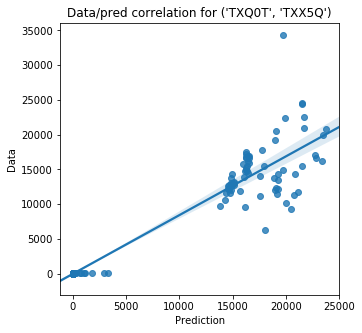

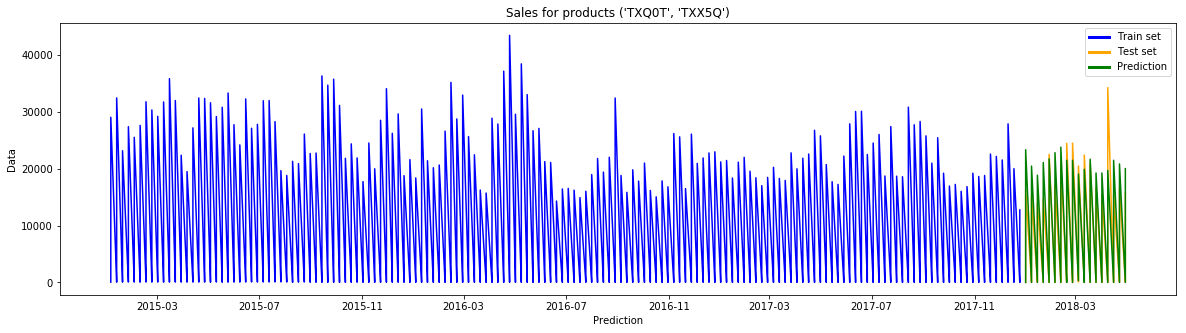

*********************************************************
Product line ('TXQQX', 'TXQT7', 'TXQTZ')
*********************************************************
[-2.60845528e+03  1.05422386e+04  5.45696821e-12  5.27618830e+02
 -3.10801482e+02 -2.16817348e+02  9.09494702e-13  1.36424205e-12
  9.09494702e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.87652658e+03 -3.53437968e+03  5.39396679e+03 -1.42743827e+03
 -5.50372965e+03 -8.04945762e+02]
The R-square_train is:  0.8015001463912534
The R-square_test is:  0.7885535339955152


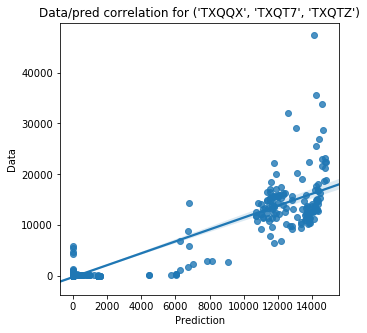

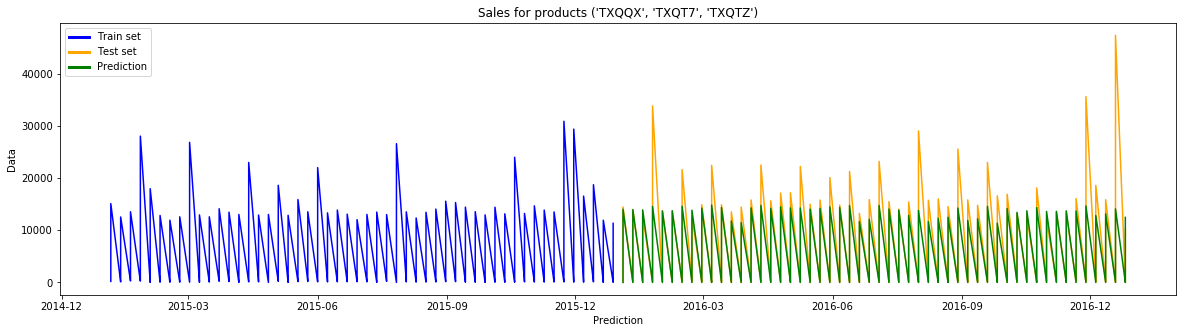

[-1.01682426e+04  9.55037532e+03 -1.27329258e-11 -3.54349891e+03
  1.24811788e+03  2.29538103e+03  0.00000000e+00 -4.54747351e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.01785796e+03 -2.44295181e+03  7.06411677e+03 -1.08819234e+02
 -6.69353515e+03 -1.83666853e+03]
The R-square_train is:  0.7974088718627244
The R-square_test is:  0.8435721874088595


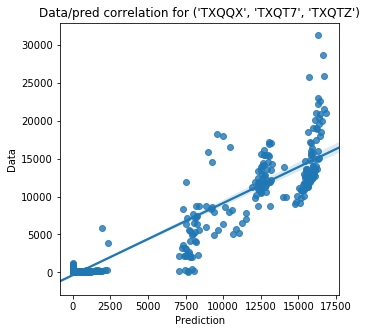

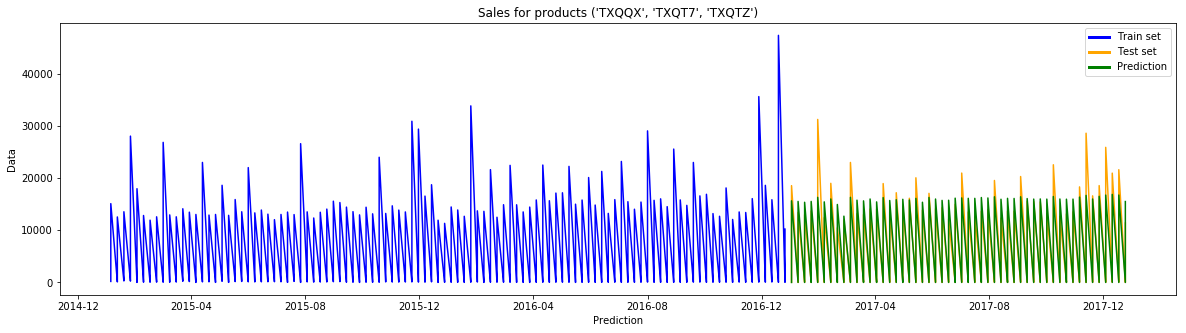

[-5.49480191e+03  9.78735713e+03  3.63797881e-12 -1.01637640e+03
  8.58325664e+01  9.30543836e+02  0.00000000e+00  1.13686838e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.00527203e+03 -2.29134707e+03  6.10596423e+03  3.11974729e+02
 -6.22816118e+03 -1.90370274e+03]
The R-square_train is:  0.8113610470026069
The R-square_test is:  0.8519612856444837


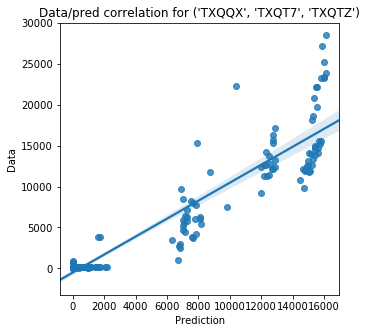

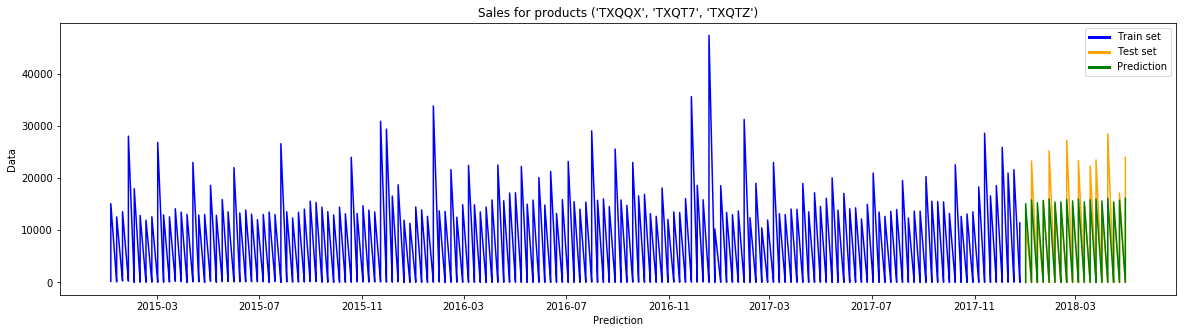

*********************************************************
Product line ('TXX00', 'TXX06', 'TXXX0', 'TXZ06', 'TZQAQ')
*********************************************************
[-5.56977113e+03 -2.78005749e+02 -7.16227078e-12  5.00222086e-12
  3.63797881e-12  3.63797881e-12 -1.65846630e+02 -4.76663848e+02
 -3.63797881e-12 -3.96108693e+02  1.03861917e+03  0.00000000e+00
 -3.36859005e+03 -3.99185744e+03  1.26477919e+04  1.83229072e+03
 -4.48571871e+03 -2.63391643e+03]
The R-square_train is:  0.9276132494313166
The R-square_test is:  0.6161202492662374


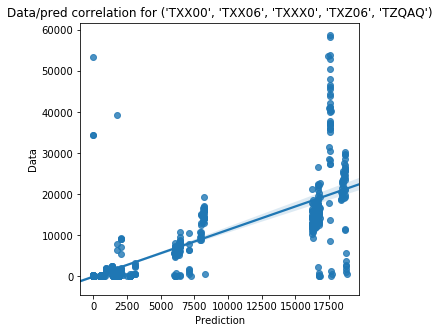

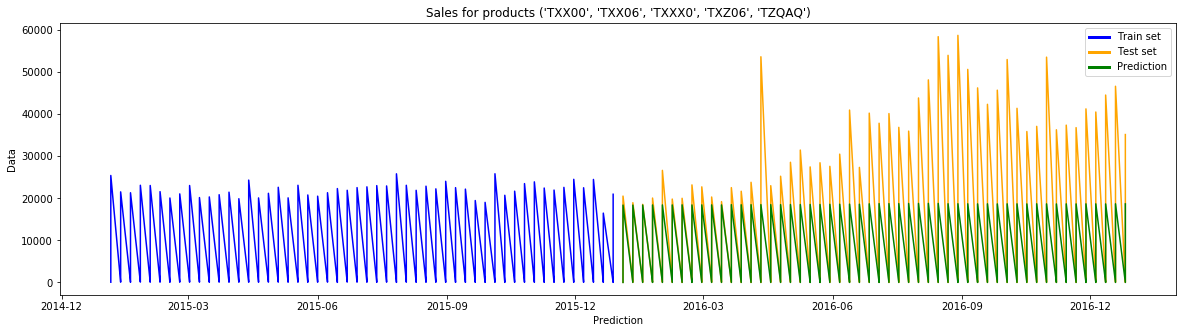

[-2.08624552e+04  9.70617865e+03  8.64019967e-12 -3.54702934e-11
  1.81898940e-12  0.00000000e+00  5.76247642e+01 -6.07070477e+02
  1.13686838e-12 -9.70392876e+02 -6.04585767e+02  2.12442436e+03
 -1.54900812e+03 -2.05073057e+03  8.93127229e+03  4.87335134e+03
 -7.18559083e+03 -3.01929409e+03]
The R-square_train is:  0.7583387453995687
The R-square_test is:  0.8197806779095467


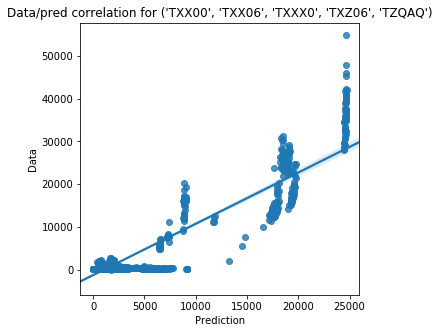

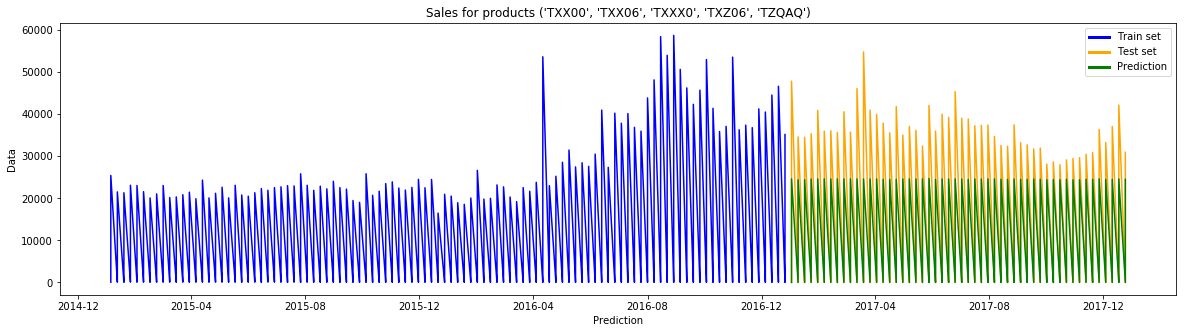

[-2.76730280e+04  7.09811270e+03  8.18545232e-12 -8.18545232e-12
 -1.81898940e-11 -9.09494702e-13  2.44704449e+02 -5.20132623e+02
 -9.09494702e-13 -9.00082694e+02 -9.38332000e+02  2.11384287e+03
 -2.48848565e+03 -1.40636373e+03  1.11694001e+04  4.30018697e+03
 -7.32693213e+03 -4.24780553e+03]
The R-square_train is:  0.7839107238318037
The R-square_test is:  0.7875698298814603


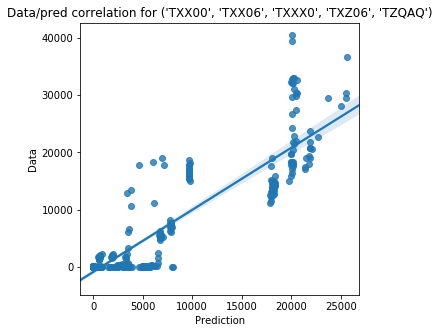

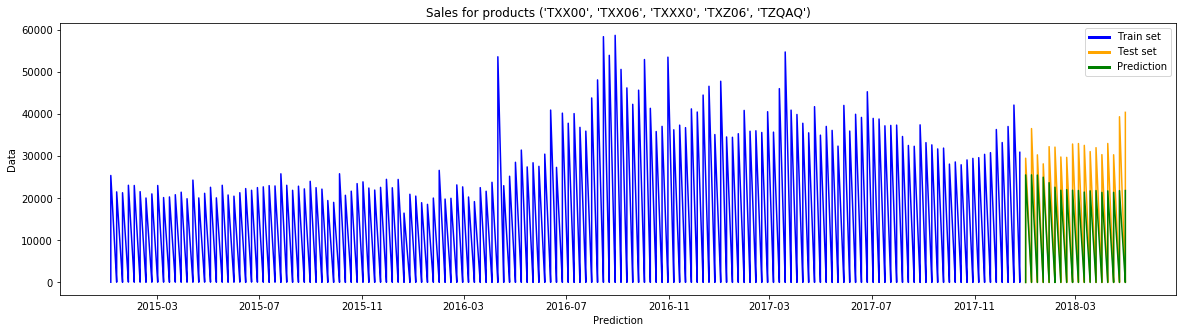

In [39]:
df_r2 = pd.DataFrame(np.array([[0, 0, 0], 
                               [0, 0, 0], 
                               [0, 0, 0]]),
                   columns=['line_1', 'line_2', 'line_3'],
                   index = ['2016', '2017', '2018'])
df_r2.index.name = 'TestYear_R2'

for j, line in enumerate(list_of_prodlines):
    ch_names = list_of_channels
    
    print("*********************************************************")
    print("Product line", line)
    print("*********************************************************")

    for i, fold in enumerate(x_train):
        x_train_prod = pd.DataFrame(columns = x_train[0].columns)
        y_train_prod = pd.DataFrame({y_train[0].index.name : []})
        x_test_prod = pd.DataFrame(columns = x_test[0].columns)
        y_test_prod = pd.DataFrame({y_test[0].index.name : []})
        for name in line:
            for channel in ch_names:
                _x_train_prod = x_train[i][(x_train[i][name] == True) & (x_train[i][channel] == True)]
                _y_train_prod = y_train[i][(x_train[i][name] == True) & (x_train[i][channel] == True)]

                _x_test_prod = x_test[i][(x_test[i][name] == True) & (x_test[i][channel] == True)]
                _y_test_prod = y_test[i][(x_test[i][name] == True) & (x_test[i][channel] == True)]

                x_train_prod = pd.concat([x_train_prod, _x_train_prod])
                y_train_prod = pd.concat([y_train_prod, _y_train_prod])
                x_test_prod = pd.concat([x_test_prod, _x_test_prod])
                y_test_prod = pd.concat([y_test_prod, _y_test_prod])


        #older data should matter less
        x_train_prod['weight'] = 1 / (min(x_test_prod.year) - x_train_prod.year)
        yearly_weights = x_train_prod['weight']
        x_train_prod.drop(columns = 'weight', axis = 1, inplace = True)
        
        x_train_prod.drop(columns = 'year', axis = 1, inplace = True)
        x_test_prod.drop(columns = 'year', axis = 1, inplace = True)

        y_train_prod = pd.Series(y_train_prod[0])
        y_test_prod = pd.Series(y_test_prod[0], index = y_test_prod.index)
        y_test_prod.index.name = y_test[0].index.name
        y_train_prod.index.name = y_test[0].index.name

        lr = LinearRegression()
        lr.fit(x_train_prod, y_train_prod)#, sample_weight = yearly_weights)

        print(lr.coef_)

        Yhat = pd.Series(lr.predict(x_test_prod), index = y_test_prod.index)
        Yhat.index.name = y_test[0].index.name
        Yhat_train = pd.Series(lr.predict(x_train_prod), index = y_train_prod.index)
        Yhat_train.index.name = y_train[0].index.name
        
        Yhat.loc[Yhat < 0] = 0

        print('The R-square_train is: ', compute_R2(y_train_prod, Yhat_train))
        print('The R-square_test is: ', compute_R2(y_test_prod, Yhat))
        
        df_r2.iloc[i, j] = round(compute_R2(y_test_prod, Yhat), 2)

        plt.figure(figsize = (5, 5))

        sns.regplot(x = Yhat, y = y_test_prod)

        plt.title('Data/pred correlation for ' + str(line))
        plt.ylabel('Data')
        plt.xlabel('Prediction')

        plt.show()

        plt.figure(figsize=(20, 5))

        sns.lineplot(data = y_train_prod,
                     color = 'blue',
                     estimator=None,
                     ci=None)

        sns.lineplot(data = y_test_prod,
                     color = 'orange',
                     estimator=None,
                     ci=None)

        sns.lineplot(data = Yhat,
                    color = 'green',
                    estimator=None,
                    ci=None)

        plt.title('Sales for products ' + str(line))
        plt.ylabel('Data')
        plt.xlabel('Prediction')

        colors = ['blue', 'orange', 'green']
        lines = [Line2D([0], [0], color = c, linewidth = 3, linestyle = '-') for c in colors]
        labels = ['Train set', 'Test set', 'Prediction']
        plt.legend(lines, labels)

        plt.show()

In [40]:
df_r2

,line_1,line_2,line_3
TestYear_R2,,,
2016,0.88,0.79,0.62
2017,0.89,0.84,0.82
2018,0.82,0.85,0.79
